In [7]:
from sklearn.linear_model import LogisticRegressionCV
import pandas as pd
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
from datetime import *


%cd "C:\Users\artemiyburov\prog\"

C:\Users\artemiyburov\prog


In [8]:
df = pd.read_csv("covid-19\data\worldwide-aggregated.csv")
#df.plot(y='Confirmed', use_index = True)

x = df.index       #features
y = df['Confirmed']#labels
x_predicted = np.arange(150)

In [9]:
def logistic_function(x,A,x0,k,off):
    return A / (1 + np.exp(-k*(x-x0)))+off

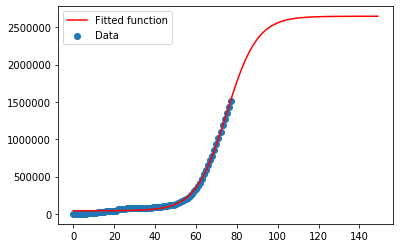

In [10]:

popt, pcov = curve_fit(logistic_function, x, y)
plt.scatter(x,y,label='Data')
plt.plot(x_predicted, logistic_function(x_predicted, *popt), 'r-',label='Fitted function')
plt.legend()


In [11]:
#create a valid filename from string
import unicodedata
import string

valid_filename_chars = "-_.() %s%s" % (string.ascii_letters, string.digits)
char_limit = 255

def clean_filename(filename, whitelist=valid_filename_chars, replace=' '):
    # replace spaces
    for r in replace:
        filename = filename.replace(r,'_')
    
    # keep only valid ascii chars
    cleaned_filename = unicodedata.normalize('NFKD', filename).encode('ASCII', 'ignore').decode()
    
    # keep only whitelisted chars
    cleaned_filename = ''.join(c for c in cleaned_filename if c in whitelist)
    if len(cleaned_filename)>char_limit:
        print("Warning, filename truncated because it was over {}. Filenames may no longer be unique".format(char_limit))
    return cleaned_filename[:char_limit]

In [13]:
df_by_country = pd.read_csv("covid-19\data\countries-aggregated.csv")
#df.loc[df_by_country["Country"] == "South Africa"]
columns = ['Province/State','Country','Target/Date','N','low95N','high95N','R','low95R','high95R','D','low95D','high95D','T','low95T','high95T','M','low95M','high95M','C','low95C','high95C']
#df2day = pd.DataFrame(columns = columns)
dfidays = pd.DataFrame(columns = columns)

for country in df_by_country.Country.unique():
    #if country == 'United Kingdom':#replace country here or add or conditions for comparison
    df_country = df_by_country.loc[df_by_country["Country"] == country].reset_index()
    x = df_country.index       #features
    y = df_country['Confirmed']#labels
    yr = df_country['Recovered']#labels recovered
    yd = df_country['Deaths']#labels deaths
    y_max = y.max()
    y_norm = y/y_max
    yr_max = yr.max()
    yr_norm = yr/yr_max
    yd_max = yd.max()
    yd_norm = yd/yd_max
    x_predicted = np.arange(200)
    try:#number fit
        popt, pcov = curve_fit(logistic_function, x, y_norm)
    except:
        continue
    try:#recovered fit
        poptr, pcovr = curve_fit(logistic_function, x, y_norm)
    except:
        continue
    try:#deaths fit
        poptd, pcovd = curve_fit(logistic_function, x, y_norm)
    except:
        continue
    y_predicted = y_max*logistic_function(x_predicted, *popt)#confidence intervals cases
    sigma = np.sqrt(np.diagonal(pcov))#sqrt of covariance matrix
    y_predicted_sup = y_max*logistic_function(x_predicted, *(popt+2*sigma))#2 standard dev
    y_predicted_inf = y_max*logistic_function(x_predicted, *(popt-2*sigma))#2 standard dev
    thickness = max(abs(y_predicted_sup-y_predicted_inf))

    yr_predicted = yr_max*logistic_function(x_predicted, *poptr)#confidence intervals recovered
    sigma = np.sqrt(np.diagonal(pcovr))#sqrt of covariance matrix
    yr_predicted_sup = yr_max*logistic_function(x_predicted, *(poptr+2*sigma))#2 standard dev
    yr_predicted_inf = yr_max*logistic_function(x_predicted, *(poptr-2*sigma))#2 standard dev
    thicknessr = max(abs(yr_predicted_sup-yr_predicted_inf))

    yd_predicted = yd_max*logistic_function(x_predicted, *poptd)#confidence intervals deaths
    sigmad = np.sqrt(np.diagonal(pcovd))#sqrt of covariance matrix
    yd_predicted_sup = yd_max*logistic_function(x_predicted, *(poptd+2*sigma))#2 standard dev
    yd_predicted_inf = yd_max*logistic_function(x_predicted, *(poptd-2*sigma))#2 standard dev
    thicknessd = max(abs(yd_predicted_sup-yd_predicted_inf))
    #2 day prediction number of cases
    today = date.today()
    #tomorrow = date.today()+timedelta(days=1)
    #aftertomorrow = date.today()+timedelta(days=2)
    l = len(df_country)#length of epidemic in a country
    prediction_lengths = [2,7,30]#choose the length of predicition here
    for prediction_length in prediction_lengths:
        #i day prediciton
        for i in np.arange(prediction_length):
            dayi = date.today()+timedelta(days=int(i+1))
            N_dayi = y_predicted[l+i]#cases
            low95N_dayi = min(y_predicted_sup[l+i],y_predicted_inf[l+i])
            high95N_dayi = max(y_predicted_sup[l+i],y_predicted_inf[l+i])
            R_dayi = yr_predicted[l+i]#recovered
            low95R_dayi = min(yr_predicted_sup[l+i],yr_predicted_inf[l+i])
            high95R_dayi = max(yr_predicted_sup[l+i],yr_predicted_inf[l+i])
            D_dayi = yd_predicted[l+i]#deaths
            low95D_dayi = min(yd_predicted_sup[l+i],yd_predicted_inf[l+i])
            high95D_dayi = max(yd_predicted_sup[l+i],yd_predicted_inf[l+i])
            new_row_dayi = {'Province/State':'','Country':country, 'Target/Date':dayi, 'N':N_dayi,'low95N':low95N_dayi,'high95N':high95N_dayi, 'R':R_dayi, 'low95R':low95R_dayi,'high95R':high95R_dayi, 'D':D_dayi, 'low95D':low95D_dayi,'high95D':high95D_dayi,'T':'','low95T':'','high95T':'','M':'','low95M':'','high95M':'','C':'','low95C':'','high95C':''}
            dfidays.loc[len(dfidays)] = new_row_dayi
        dfidays.to_csv("epidemic-datathon\{}day_prediction_{}.csv".format(prediction_length,today),index=False)

'''
    N_day1 = y_predicted[l]#cases
    N_day2 = y_predicted[l+1]
    low95N_day1 = min(y_predicted_sup[l],y_predicted_inf[l])
    low95N_day2 = min(y_predicted_sup[l+1],y_predicted_inf[l+1])
    high95N_day1 = max(y_predicted_sup[l],y_predicted_inf[l])
    high95N_day2 = max(y_predicted_sup[l+1],y_predicted_inf[l+1])

    R_day1 = yr_predicted[l]#recovered
    R_day2 = yr_predicted[l+1]
    low95R_day1 = min(yr_predicted_sup[l],yr_predicted_inf[l])
    low95R_day2 = min(yr_predicted_sup[l+1],yr_predicted_inf[l+1])
    high95R_day1 = max(yr_predicted_sup[l],yr_predicted_inf[l])
    high95R_day2 = max(yr_predicted_sup[l+1],yr_predicted_inf[l+1])

    D_day1 = yd_predicted[l]#deaths
    D_day2 = yd_predicted[l+1]
    low95D_day1 = min(yd_predicted_sup[l],yd_predicted_inf[l])
    low95D_day2 = min(yd_predicted_sup[l+1],yd_predicted_inf[l+1])
    high95D_day1 = max(yd_predicted_sup[l],yd_predicted_inf[l])
    high95D_day2 = max(yd_predicted_sup[l+1],yd_predicted_inf[l+1])

    
    new_row_day1 = {'Province/State':'','Country':country, 'Target/Date':tomorrow, 'N':N_day1, 'low95N':low95N_day1,'high95N':high95N_day1, 'R':R_day1, 'low95R':low95R_day1,'high95R':high95R_day1, 'D':D_day1, 'low95D':low95D_day1,'high95D':high95D_day1,'T':'','low95T':'','high95T':'','M':'','low95M':'','high95M':'','C':'','low95C':'','high95C':''}
    new_row_day2 = {'Province/State':'','Country':country, 'Target/Date':aftertomorrow, 'N':N_day2, 'low95N':low95N_day2,'high95N':high95N_day2, 'R':R_day2, 'low95R':low95R_day2,'high95R':high95R_day2, 'D':D_day2, 'low95D':low95D_day2,'high95D':high95D_day2,'T':'','low95T':'','high95T':'','M':'','low95M':'','high95M':'','C':'','low95C':'','high95C':''}
    df2day.loc[len(df2day)] = new_row_day1
    df2day.loc[len(df2day)] = new_row_day2
    df2day.to_csv("epidemic-datathon\2day_prediction_{}.csv".format(today),index=False)
'''
'''
    #plotting number
    if thickness>.1 and thickness<y_max and y_max<=y_predicted.max():#
        #plot
        fig = plt.figure()
        plt.scatter(x,y,label='Data cases '+country)
        plt.plot(x_predicted, y_predicted, 'r-',label='Total cases fit '+country)
        plt.fill_between(x_predicted, y_predicted_inf, y_predicted_sup, color = 'black', alpha = 0.15)
        plt.legend()
        #save into a file
        fig.savefig("epidemic-datathon\plots\plots-total-cases\{}-total-cases-{}".format(clean_filename(country), today))
        plt.close()
    #plotting recovered
    if thicknessr>.1 and thicknessr<yr_max and yr_max<=yr_predicted.max():#
        #plot
        fig = plt.figure()
        plt.scatter(x,yr,label='Data recovered '+country)
        plt.plot(x_predicted, yr_predicted, 'r-',label='Total recovered fit '+country)
        plt.fill_between(x_predicted, yr_predicted_inf, yr_predicted_sup, color = 'black', alpha = 0.15)
        plt.legend()
        #save into a file
        fig.savefig("epidemic-datathon\plots\plots-total-recovered\{}-total-recovered-{}".format(clean_filename(country), today))
        plt.close()
    #plotting deaths
    if thicknessd>.1 and thicknessd<yd_max and yd_max<=yd_predicted.max():#
        #plot
        fig = plt.figure()
        plt.scatter(x,yd,label='Data deaths '+country)
        plt.plot(x_predicted, yd_predicted, 'r-',label='Total deaths fit '+country)
        plt.fill_between(x_predicted, yd_predicted_inf, yd_predicted_sup, color = 'black', alpha = 0.15)
        plt.legend()
        #save into a file
        fig.savefig("epidemic-datathon\plots\plots-total-deaths\{}-total-deaths-{}".format(clean_filename(country), today))
        plt.close()
'''

'\n    #plotting number\n    if thickness>.1 and thickness<y_max and y_max<=y_predicted.max():#\n        #plot\n        fig = plt.figure()\n        plt.scatter(x,y,label=\'Data cases \'+country)\n        plt.plot(x_predicted, y_predicted, \'r-\',label=\'Total cases fit \'+country)\n        plt.fill_between(x_predicted, y_predicted_inf, y_predicted_sup, color = \'black\', alpha = 0.15)\n        plt.legend()\n        #save into a file\n        fig.savefig("epidemic-datathon\\plots\\plots-total-cases\\{}-total-cases-{}".format(clean_filename(country), today))\n        plt.close()\n    #plotting recovered\n    if thicknessr>.1 and thicknessr<yr_max and yr_max<=yr_predicted.max():#\n        #plot\n        fig = plt.figure()\n        plt.scatter(x,yr,label=\'Data recovered \'+country)\n        plt.plot(x_predicted, yr_predicted, \'r-\',label=\'Total recovered fit \'+country)\n        plt.fill_between(x_predicted, yr_predicted_inf, yr_predicted_sup, color = \'black\', alpha = 0.15)\n        p